# Predicting Style Probability by Painting Features

Author: Yangyu Wang, Gio Choi, Avi Oberoi

Date: 02/11/2025

## Table of Contents

1. [Data Preprocessing](#Data-Preprocessing)
2. [Tree-based Model](#Tree-based-Model:-Random-Forest)
3. [Linear Model](#Linear-Model)
4. [Model Comparison & Results](#Model-Comparison-&-Results)

## Data Preprocessing

In [1]:
#Avi, Please add your code here

## EDA

1. Processing data

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [3]:
painting_feature = pd.read_csv("data/artwork_with_clip_features.csv")

In [4]:
def string_to_array(s):
    '''
    Change the string-like array into numpy.array
    Parameter:
        s: string to change with an array structure
    Output: array
    '''
    return np.fromstring(s.strip("[]"), sep=" ").tolist()

painting_feature['Feature_array'] = painting_feature['Feature'].apply(string_to_array)

In [5]:
print(painting_feature['Feature_array'][0][0])

0.035522


In [6]:
len(set(painting_feature["Style_Category"]))

16

In [7]:
painting_feature.head()

,Artwork_ID,Artist_name,Year,image_n,Style_Category,Feature,Feature_array
0,9,a-y-jackson,1919,46467,Impressionism & Post-Impressionism,[ 3.5522e-02 -5.0446e-02 3.7323e-02 1.8173e-...,"[0.035522, -0.050446, 0.037323, 0.018173, -0.0..."
1,10,a-y-jackson,1918,73382,Art Nouveau & Deco,[-2.8248e-03 -2.7283e-02 2.2278e-02 1.8936e-...,"[-0.0028248, -0.027283, 0.022278, 0.018936, -0..."
2,11,a-y-jackson,1951,64112,Impressionism & Post-Impressionism,[ 3.4515e-02 -7.7515e-03 3.0270e-03 1.6342e-...,"[0.034515, -0.0077515, 0.003027, 0.016342, -0...."
3,12,a-y-jackson,1920,2173,Impressionism & Post-Impressionism,[-1.0796e-02 7.4120e-03 1.1635e-02 4.5807e-...,"[-0.010796, 0.007412, 0.011635, 0.045807, 0.00..."
4,13,a-y-jackson,1933,74330,Art Nouveau & Deco,[-1.3092e-02 -1.0653e-03 5.2887e-02 -4.5700e-...,"[-0.013092, -0.0010653, 0.052887, -0.00457, -0..."


Here we do not directly encode the Style_Category, because for tree-based and linear model, y should be encoded in different ways. Detailed processing on the y, please check each part.

2. Visualization

In [8]:
# Avi, could you add some dimension detection on features here?

Visualization by Years and Style categories

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
painting_feature_nondup = painting_feature.drop_duplicates("image_n")

In [13]:
yearly_counts = painting_feature_nondup.groupby("Year").size().reset_index(name="Artwork_Count")

In [14]:
yearly_counts["Year"] = yearly_counts["Year"].astype(int)

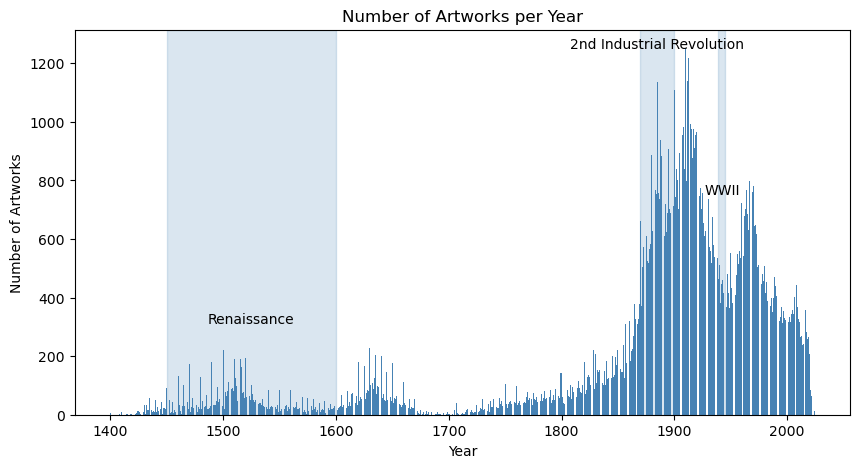

In [49]:
plt.figure(figsize=(10, 5))
ax = plt.bar(data=yearly_counts, x="Year", height="Artwork_Count", color="steelblue")

plt.xlabel("Year")
plt.ylabel("Number of Artworks")
plt.title("Number of Artworks per Year")

plt.axvspan(1450, 1600, color='steelblue', alpha=0.2)
plt.text(1525, yearly_counts["Artwork_Count"].max() * 0.25, "Renaissance", fontsize=10, color="black", ha='center')

plt.axvspan(1870, 1900, color='steelblue', alpha=0.2)
plt.text(1885, yearly_counts["Artwork_Count"].max() * 1, "2nd Industrial Revolution", fontsize=10, color="black", ha='center')

plt.axvspan(1939, 1945, color='steelblue', alpha=0.2)
plt.text(1942.5, yearly_counts["Artwork_Count"].max() * 0.6, "WWII", fontsize=10, color="black", ha='center')

plt.show()

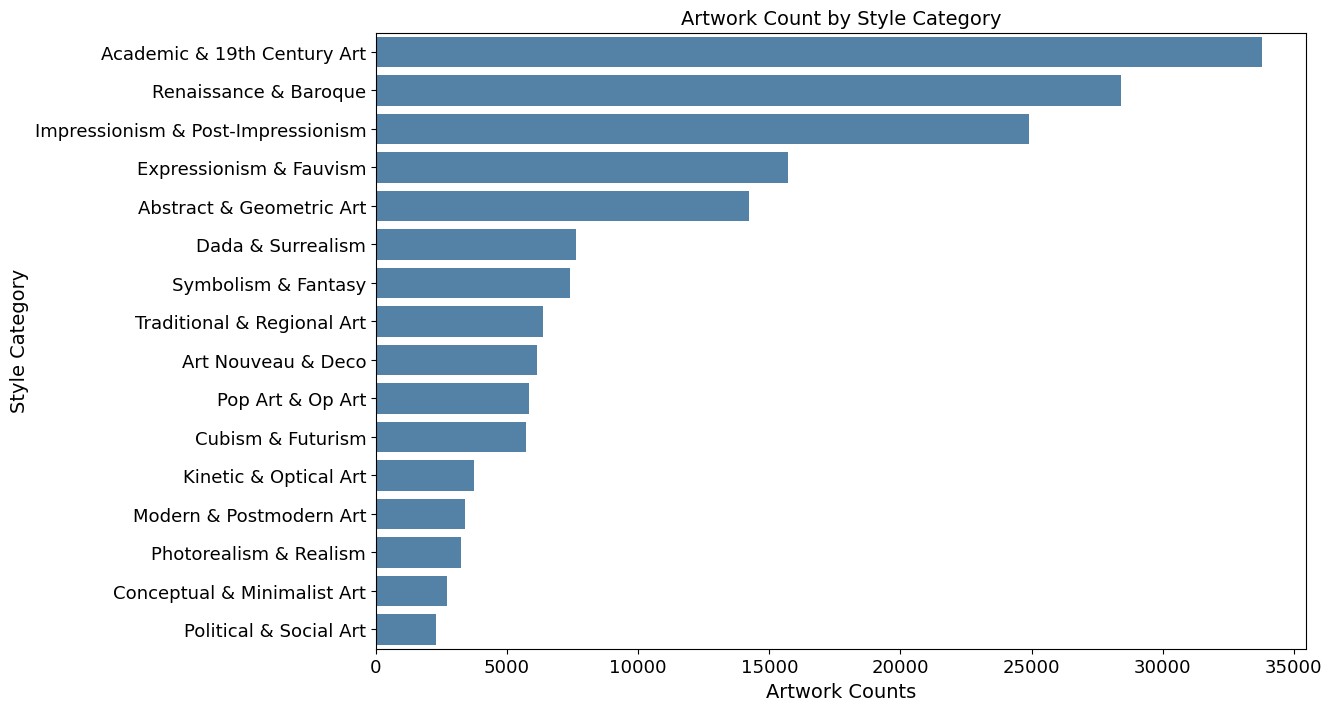

In [51]:
style_counts = painting_feature["Style_Category"].value_counts().reset_index()
style_counts.columns = ["Style_Category", "Count"]

plt.figure(figsize=(12, 8))
sns.barplot(data=style_counts, x="Count", y="Style_Category", color="steelblue")
plt.xlabel("Artwork Counts", fontsize=14)
plt.ylabel("Style Category", fontsize=14)
plt.title("Artwork Count by Style Category", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

3. Split on training and testing dataset

Because of the imbalanced structure of our dataset, we sample 800 for each categories to train the model and 200 to test.

In [50]:
train_samples = []
test_samples = []

# Sample 800 instances per category for train and 200 for test
for style, group in painting_feature.groupby('Style_Category'):
    train_sample, test_sample = train_test_split(group, train_size=800, test_size=200, random_state=42, stratify=group['Style_Category'])
    print(style, len(group))
    
    train_samples.append(train_sample)
    test_samples.append(test_sample)

balanced_train_df = pd.concat(train_samples)
balanced_test_df = pd.concat(test_samples)


Abstract & Geometric Art 14217
Academic & 19th Century Art 33771
Art Nouveau & Deco 6144
Conceptual & Minimalist Art 2719
Cubism & Futurism 5709
Dada & Surrealism 7638
Expressionism & Fauvism 15717
Impressionism & Post-Impressionism 24896
Kinetic & Optical Art 3725
Modern & Postmodern Art 3381
Photorealism & Realism 3235
Political & Social Art 2292
Pop Art & Op Art 5821
Renaissance & Baroque 28405
Symbolism & Fantasy 7391
Traditional & Regional Art 6369


In [51]:
len(balanced_train_df)

12800

## Tree-based Model: Random Forest

1. Data processing

We chose label encoder here, for tree-based do not require any additional encoding to deal with tasks.

In [54]:
from sklearn.preprocessing import LabelEncoder

In [55]:
labelencoder = LabelEncoder()

In [103]:
X_train = np.vstack(balanced_train_df["Feature_array"])
y_train = np.array(balanced_train_df['Style_Category'])

X_test = np.vstack(balanced_test_df["Feature_array"])
y_test = np.array(balanced_test_df['Style_Category'])

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (12800, 512), y_train shape: (12800,)
X_test shape: (3200, 512), y_test shape: (3200,)


2. Random Forest & Model Evaluation

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [105]:
rfc_1 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
rfc_1.fit(X_train, y_train)
np.round(rfc_1.score(X_test,y_test),3)

0.502

In [121]:
y_pred_rfc_1 = rfc_1.predict(X_test)
y_probs_rfc_1 = rfc_1.predict_proba(X_test)  # Shape: (n_samples, n_classes)
confusion_matrix(y_test, y_pred_rfc_1, labels=rfc_1.classes_)

array([[ 87,   0,   2,  18,  10,   9,   5,   0,  47,   2,   5,   2,   7,
          0,   0,   6],
       [  1, 112,  10,   0,   2,   0,   0,  29,   0,   3,   3,   6,   0,
         27,   7,   0],
       [  2,  20,  92,   6,   4,   8,   8,  17,   1,   2,   5,  11,   2,
          6,  13,   3],
       [ 20,   0,   2, 130,   0,   1,   0,   0,   9,   5,   3,   8,  18,
          0,   1,   3],
       [  9,   0,   4,   0, 141,  13,  11,   7,   2,   1,   0,   6,   3,
          0,   2,   1],
       [  8,   2,   8,  11,  33,  74,   8,   2,   9,   5,   2,   8,   8,
          2,  16,   4],
       [  3,   9,  10,   3,  35,   9,  57,  27,   9,  14,   1,   2,   4,
          0,   8,   9],
       [  0,  25,   6,   1,   0,   3,   7, 144,   0,   0,   5,   1,   0,
          2,   5,   1],
       [ 30,   0,   0,  11,   9,   5,   0,   1, 130,   2,   1,   0,  10,
          0,   0,   1],
       [  3,   4,   2,  11,   0,   7,   6,   9,  19,  91,  10,  13,   9,
          3,   7,   6],
       [  1,  13,   4,  10,   

In [108]:
print(classification_report(y_test, y_pred_rfc_1, zero_division=np.nan))

                                    precision    recall  f1-score   support

          Abstract & Geometric Art       0.46      0.43      0.45       200
       Academic & 19th Century Art       0.47      0.56      0.51       200
                Art Nouveau & Deco       0.49      0.46      0.47       200
       Conceptual & Minimalist Art       0.53      0.65      0.59       200
                 Cubism & Futurism       0.53      0.70      0.61       200
                 Dada & Surrealism       0.42      0.37      0.39       200
           Expressionism & Fauvism       0.38      0.28      0.32       200
Impressionism & Post-Impressionism       0.51      0.72      0.60       200
             Kinetic & Optical Art       0.48      0.65      0.55       200
           Modern & Postmodern Art       0.50      0.46      0.48       200
            Photorealism & Realism       0.50      0.36      0.42       200
            Political & Social Art       0.48      0.46      0.47       200
           

In [122]:
roc_score_1 = roc_auc_score(y_test, y_probs_rfc_1, multi_class='ovo')
roc_score_1

0.89542984375

In [111]:
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=rfc_1.classes_)

roc_per_class_1 = roc_auc_score(y_test_bin, y_probs_rfc_1, average=None)

for style, roc in zip(rfc_1.classes_, roc_per_class_1):
    print("ROC-AUC for", style, ":", roc)

ROC-AUC for Abstract & Geometric Art : 0.8992175000000001
ROC-AUC for Academic & 19th Century Art : 0.9222108333333333
ROC-AUC for Art Nouveau & Deco : 0.8974783333333334
ROC-AUC for Conceptual & Minimalist Art : 0.9404508333333333
ROC-AUC for Cubism & Futurism : 0.9324625
ROC-AUC for Dada & Surrealism : 0.8759983333333333
ROC-AUC for Expressionism & Fauvism : 0.8251141666666666
ROC-AUC for Impressionism & Post-Impressionism : 0.9401774999999999
ROC-AUC for Kinetic & Optical Art : 0.9507083333333334
ROC-AUC for Modern & Postmodern Art : 0.8414941666666667
ROC-AUC for Photorealism & Realism : 0.8736308333333332
ROC-AUC for Political & Social Art : 0.8865025
ROC-AUC for Pop Art & Op Art : 0.8442733333333333
ROC-AUC for Renaissance & Baroque : 0.9874491666666667
ROC-AUC for Symbolism & Fantasy : 0.83826
ROC-AUC for Traditional & Regional Art : 0.8714491666666668


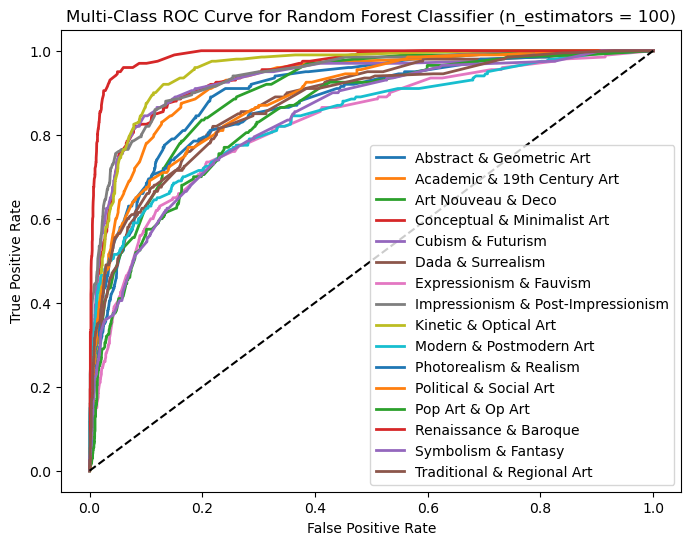

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from itertools import cycle

# Compute ROC curve for each class
n_classes = len(rfc_1.classes_)

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#f4a261", "#e76f51", "#2a9d8f", "#264653", "#ffcc00", "#800000"
]
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs_rfc_1[:, i])
    plt.plot(fpr, tpr, lw=2, label=rfc_1.classes_[i])

plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve for Random Forest Classifier (n_estimators = 100)")
plt.legend()
plt.show()

3. Error analysis

## Linear Model

## Model-Comparison-&-Results